ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **07Sep21**

# 04a. World Population Finite Element Basis Functions Least-Squares Residual
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Gmtrx}{\boldsymbol{\mathsf{G}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [FEM Lagrange Basis Functions](#lagrange)
* [Basis Functions Evaluation Matrix](#eval-matrix)
<br><br>
* [Collocation Approximation](#coll)
  + [Collocation Points](#coll-pts)
  + [Collocation Matrix](#coll-matrix)
  + [Optimal Combination Coefficients](#coll-optimal-coeff)
  + [Best Approximant Function](#coll-approximant)
  + [Results](#coll-res)
  + [Errors](#coll-error)
  + [Residual](#coll-residual)
* [Continuous Approximation ($m\rightarrow\infty$)](#cont)
  + [Gram Matrix](#gram-matrix)
  + [Load Vector](#load-vector)
  + [Optimal Combination Coefficients](#cont-optimal-coeff)
  + [Best Approximant Function](#cont-approximant)
  + [Results](#cont-res)
  + [Errors](#cont-error)
  + [Residual](#cont-residual)
  + [Comparison to Collocation Method](#cont-comparison)
* [Constrained Continuous Approximation ($m\rightarrow\infty$)](#ctr_cont)
  + [Gram Matrix](#ctr_gram-matrix)
  + [Load Vector](#ctr_load-vector)
  + [Optimal Combination Coefficients](#ctr_cont-optimal-coeff)
  + [Best Approximant Function](#ctr_cont-approximant)
  + [Results](#ctr_cont-res)
  + [Errors](#ctr_cont-error)
  + [Residual](#ctr_cont-residual)
  + [Comparison to Unconstrained and Collocation Method](#ctr_cont-comparison)
* [Experiment #1](#ex1)
  + [Collocation Approximation](#ex1_coll)
  + [Continuous Approximation ($m\rightarrow\infty$)](#ex1_cont)
  + [Constrained Continuous Approximation ($m\rightarrow\infty$)](#ex1_ctr_cont)
---

## [Objectives](#toc)<a id="obj"></a>

 + Practical use of finite element Lagrange basis functions to approximate a given function via the Galerkin Linear Least-Squares method.
 + Review [Introduction Notebook 01](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/01-introduction.ipynb)
 + Notes here (OneNote [fem-basis-func](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Evw7drHQs_ZMqvRqjb762w8BtVaiw2QrQKjQwYf6qCN4Sg?e=v6nG9O))

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$, compute an approximant $g:[a,b]\rightarrow\Reals$.

# shape pts =  12


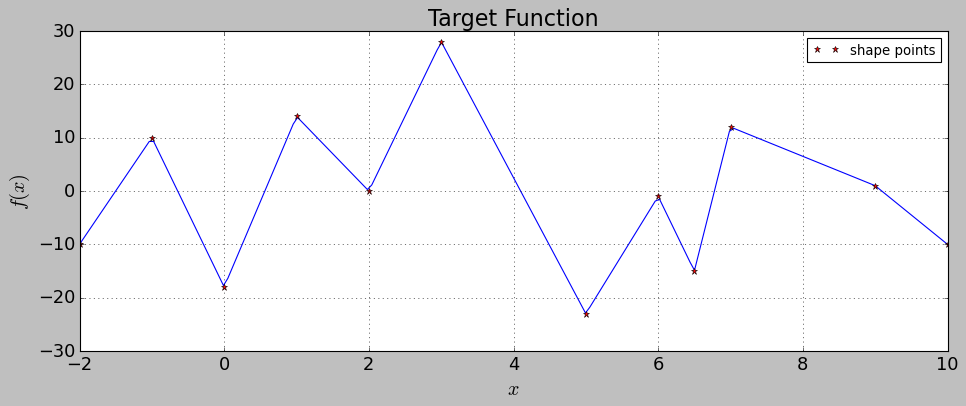

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
url = 'https://ourworldindata.org/wp-content/uploads/2013/05/WorldPopulationAnnual12000years_interpolated_HYDEandUNto2015.csv'

import pandas as pd


shape_pts = [(-2,-10), (-1,10), (0,-18), (1,14), (2,0), (3,28), (5,-23), (6, -1), (6.5, -15), (7,12), (9,1), (10,-10)]
print('# shape pts = ', len(shape_pts))

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

## [FEM Lagrange Basis Functions](#toc)<a id="lagrange"></a>

Using finite elements Lagrange basis functions 

\begin{equation*}
   V := \{\phi_i\, \mid \, k=0,\ldots,N\},
\end{equation*}

and the collocation points $\tilde{\xvec}$, compute the best approximant function of $f:\Reals\rightarrow \Reals$ by minimizing the residual vector on the collocation points.

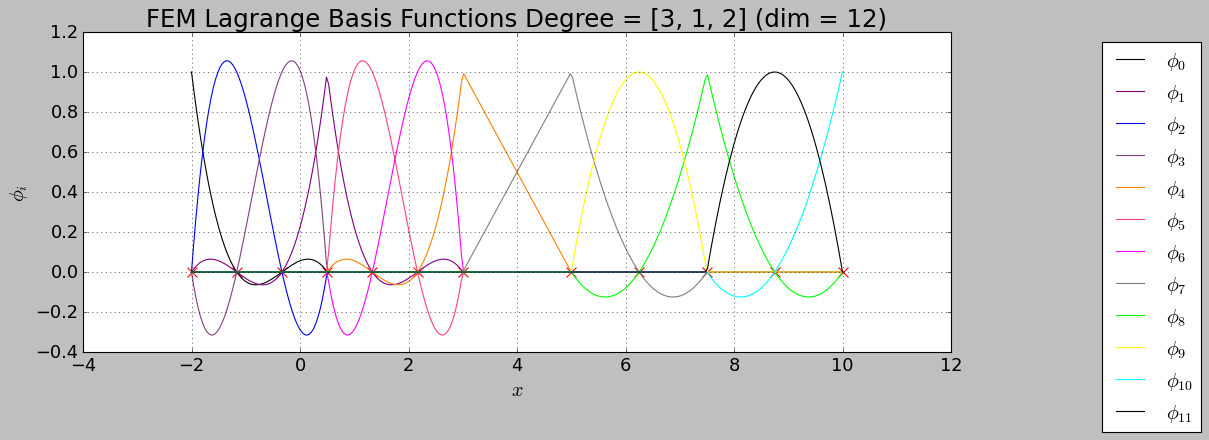

In [2]:
'''Build the basis functions'''

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

try:    
    from engy_5310.toolkit import LagrangeFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
femlb = LagrangeFEMBasis(degree=[3,1,2], n_elem=[2,1,2], x_partition=[x_min, 3, 5, x_max])
femlb.plot(n_plot_pts=300)

In [3]:
'''Mesh artifact'''

for e_id, partition in enumerate(femlb.patches):
    printout = list()
    gnode_ids = femlb.local_to_global_node_map[e_id]
    printout.append('element #%i:'%e_id)
    for lnode_id, gnode_id in enumerate(gnode_ids):
        printout[-1] += ' x_%i = %+5.2e'%(gnode_id, partition[lnode_id])
    print(printout)

['element #0: x_0 = -2.00e+00 x_3 = +5.00e-01 x_1 = -1.17e+00 x_2 = -3.33e-01']
['element #1: x_3 = +5.00e-01 x_6 = +3.00e+00 x_4 = +1.33e+00 x_5 = +2.17e+00']
['element #2: x_6 = +3.00e+00 x_7 = +5.00e+00']
['element #3: x_7 = +5.00e+00 x_9 = +7.50e+00 x_8 = +6.25e+00']
['element #4: x_9 = +7.50e+00 x_11 = +1.00e+01 x_10 = +8.75e+00']


## [Basis Functions Evaluation Matrix](#toc)<a id="eval-matrix"></a>

Build the *basis functions evaluation matrix* $\Amtrx(\xvec)$ as a $m\times n$ real matrix, that is:


## [Collocation Approximation](#toc)<a id="coll"></a>

### [Collocation Points](#toc)<a id="coll-pts"></a>

Select *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$.

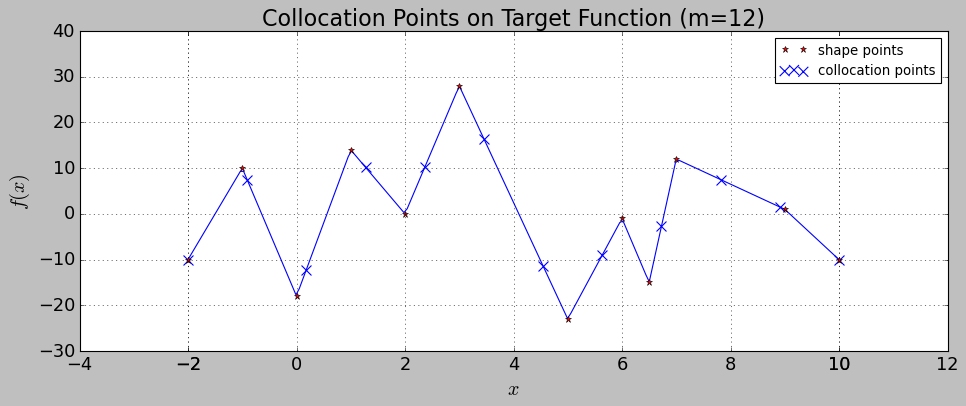

In [4]:
'''Collocation abscissa points'''
import numpy as np

m = 12
assert m >= len(shape_pts)

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function (m='+str(m)+')')

### [Basis Functions Collocation Matrix](#toc)<a id="coll-matrix"></a>

Create the *basis functions collocation matrix* by evaluating the basis function evaluation matrix on the collocation points $\tilde{\Amtrx} = \Amtrx(\tilde{\xvec})$.

In [5]:
'''Build the basis functions collocation matrix'''

a_tilde_mtrx = femlb.evaluation_matrix(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is determined.
A is rank deficient.


In [6]:
'''Build target function vector at the collocation points'''

f_tilde_vec = f(x_tilde_pts)

### [Optimal Combination Coefficients](#toc)<a id="coll-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values (this is not a sufficient condition but a good start). Otherwise the least-squares method for rank-deficient problem must be employed and the shortest, minimal residual 2-norm computed. Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient vector is denoted $\tilde{\cvec}^*$.

In addition to $\tilde{\cvec}^*$, compute the residual 2-norm

\begin{equation*}
 \norm{\tilde{\rvec}(\tilde{\cvec}^*)}_2 =  \norm{\tilde{\fvec} - \tilde{\Amtrx}\,\tilde{\cvec}^*}_2 ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [7]:
'''Compute optimal coefficient vector'''

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if np.linalg.matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
    
print('')
print('c_tilde_star_vec:\n', c_tilde_star_vec)
        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is rank deficient; solve for shortest least squares

c_tilde_star_vec:
 [-10.   -5.4  11.7  -6.9  26.5  10.3   9.1 -20.2   5.6  -4.8 -10.2   3.3]

||r^*||_2 =  4.452e+00


### [Best Approximant Function](#toc)<a id="coll-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec_\text{best}(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [8]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = femlb.evaluation_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

### [Results](#toc)<a id="coll-res"></a>

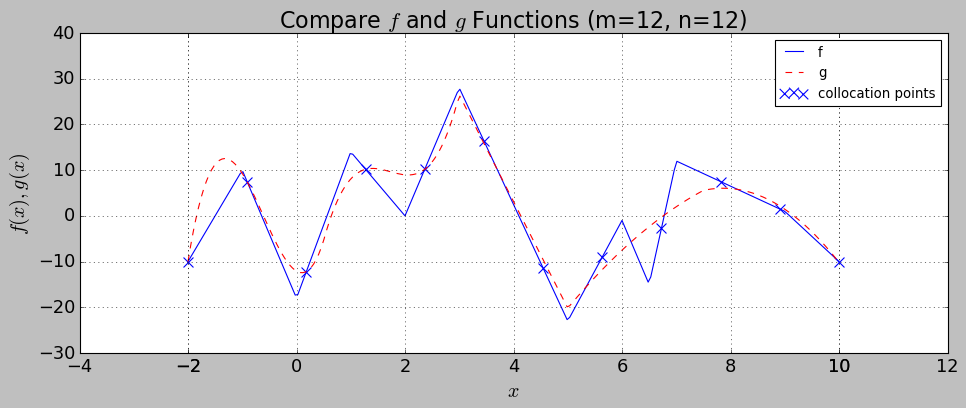

In [9]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ Functions (m='+str(m)+', n='+str(len(femlb.basis_func_list))+')')

### [Errors](#toc)<a id="coll-error"></a>

Errors are instrumental to judge how good an approximation is. However there is no one absolute strategy to judge the quality of an approximation. Here we list a few possibilities.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [10]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 36.98197759332081

||g||_L2 = 34.458239583537406

||f-g||_L2 = 14.312970683325354

Relative error [%] = 38.70255625786321


### [Residual](#toc)<a id="coll-residual"></a>

**The residual vector mapping also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  7
Negatives at collocation pts =  5
Positives =  199
Negatives =  301


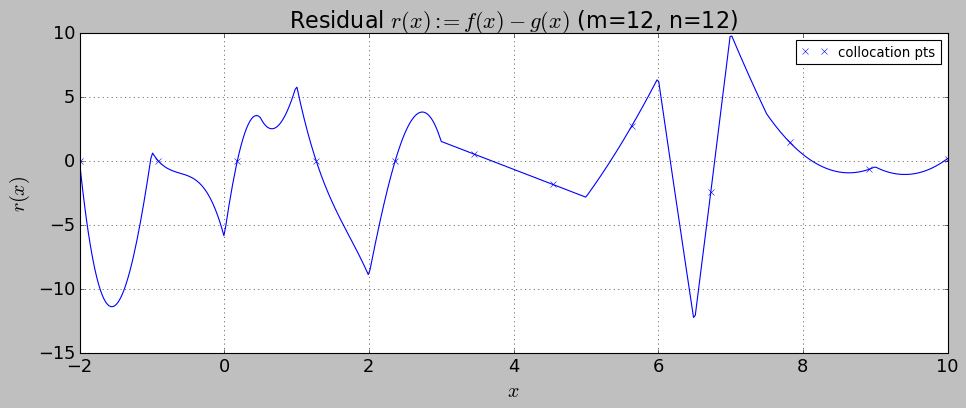

In [11]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 500)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'bx',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (m='+str(m)+', n='+str(femlb.n_gnodes)+')', fontsize=20)

plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**$\Rightarrow$ Case study:** 
>Try $2N+1 > m$ for a rank deficient case.

## [Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="cont"></a>

### [Gram Matrix](#toc)<a id="gram-matrix"></a>

Build the matrix of inner products of the basis functions, the *Gram matrix* or also called the *mass matrix*: ${(\Gmtrx)}_{i,j} = (\phi_i, \phi_j)$.

In [12]:
'''Build the Gram matrix'''

gram_mtrx = femlb.gram_matrix()

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


### [Load Vector](#toc)<a id="load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i)$ by computing the inner product of $f$ with each basis function member.

In [13]:
'''Build load vector'''

b_vec = np.zeros(len(femlb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(femlb.basis_func_list):
    (b_vec[i], _) = femlb.inner_product(f, phi_i)      

### [Optimal Combination Coefficients](#toc)<a id="cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In addition to $\cvec^*$, compute the residual $L^2(a,b)$ norm

\begin{equation*}
 \norm{r(\cvec^*)}_{L^2(a,b)} = \norm{f - g(\cvec^*)}_{L^2(a,b)} ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [14]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

### [Best Approximant Function](#toc)<a id="cont-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\cvec^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$.

In [15]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = femlb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

### [Results](#toc)<a id="cont-res"></a>

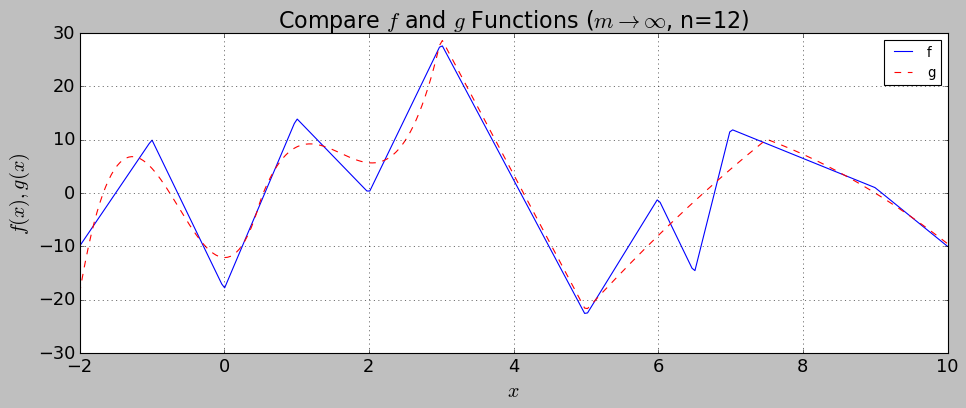

In [16]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')')

### [Errors](#toc)<a id="cont-error"></a>

Errors are measured using functional norms.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [17]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 36.98197759332081

||g||_L2 = 35.36424184886226

||f-g||_L2 = 10.818367022600743

Relative error [%] = 29.25307873355753


### [Residual](#toc)<a id="cont-residual"></a>

**The residual function also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives =  106
Negatives =  144


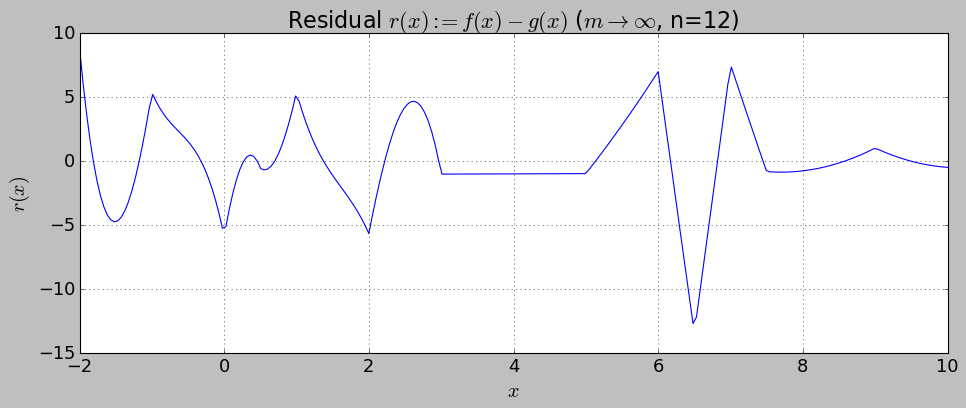

In [18]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### [Comparison to Collocation Method](#toc)<a id="cont-comparison"></a>

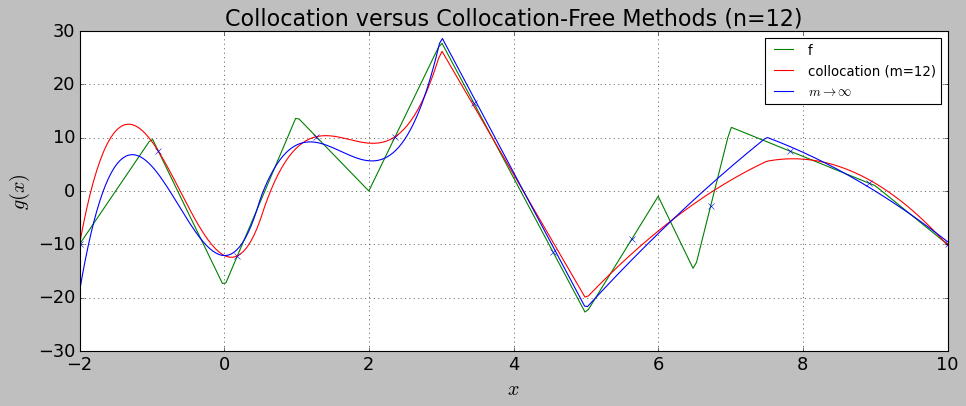

In [19]:
'''Code for comparison to collocation method'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

#plt.plot([p[0] for p in shape_pts], [p[1] for p in shape_pts],'r*')
plt.plot(x_tilde_pts, f(x_tilde_pts), 'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** The end points of the approximation in the continuous case ($m\rightarrow \infty$) are not as well approximated compared to the collocation method. This is because the continuous case leaves the end points unconstrained.

## [Contrained Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ctr_cont"></a>

### [Constrained Gram Matrix](#toc)<a id="ctr_gram-matrix"></a>

Build the matrix of inner products of the basis functions, the *Gram matrix* or also called the *mass matrix*: ${(\Gmtrx)}_{i,j} = (\phi_i, \phi_j) + \phi_i(a)\phi_j(a) + \phi_i(b)\phi_j(b)$.

In [20]:
'''Build the Gram matrix'''

gram_mtrx = femlb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


### [Load Vector](#toc)<a id="ctr_load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i) + f(a)\phi_i(a) + f(b)\phi_i(b)$ by computing the inner product of $f$ with each basis function member.

In [21]:
'''Build load vector'''

b_vec = np.zeros(len(femlb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(femlb.basis_func_list):
    (b_vec[i], _) = femlb.inner_product(f, phi_i) \
                  + f(x_min)*phi_i(x_min) + f(x_max)*phi_i(x_max)               

### [Optimal Combination Coefficients](#toc)<a id="ctr_cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In addition to $\cvec^*$, compute the residual $L^2(a,b)$ norm

\begin{equation*}
 \norm{r(\cvec^*)}_{L^2(a,b)} = \norm{f - g(\cvec^*)}_{L^2(a,b)} ,
\end{equation*}

which is the square root of the quantity to be minimized.

In [22]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

### [Best Approximant Function](#toc)<a id="ctr_cont-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\cvec^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$.

In [23]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = femlb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

### [Results](#toc)<a id="ctr_cont-res"></a>

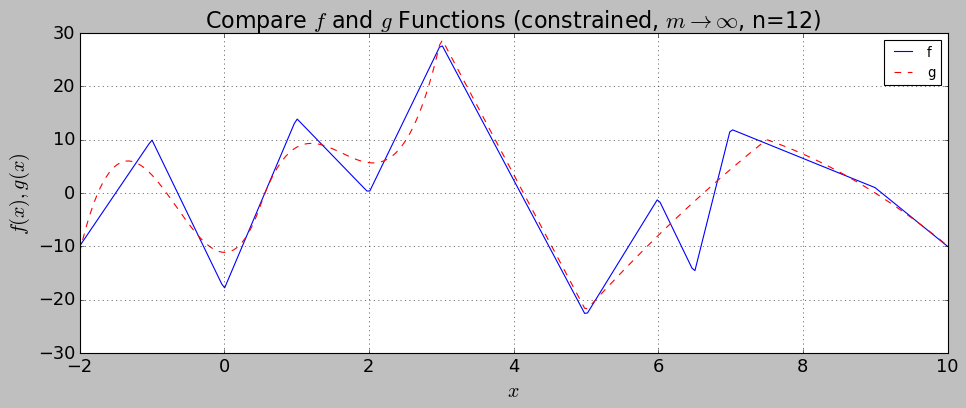

In [24]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_3 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_3), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions (constrained, $m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')')

### [Errors](#toc)<a id="ctr_cont-error"></a>

Errors are measured using functional norms.

**Relative $L^2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L^2(a,b)} }{ \norm{f}_{L^2(a,b)}} \, 100 .
\end{equation*}


In [25]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 36.98197759332081

||g||_L2 = 34.86781858189725

||f-g||_L2 = 11.246057207015264

Relative error [%] = 30.40956146446418


### [Residual](#toc)<a id="ctr_cont-residual"></a>

**The residual function also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives =  112
Negatives =  138


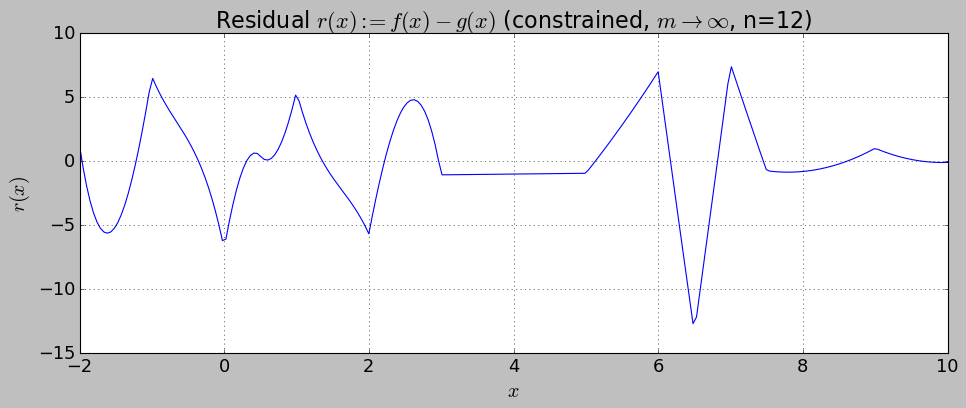

In [26]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (constrained, $m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

### [Comparison to Unconstrained and Collocation Method](#toc)<a id="ctr_cont-comparison"></a>

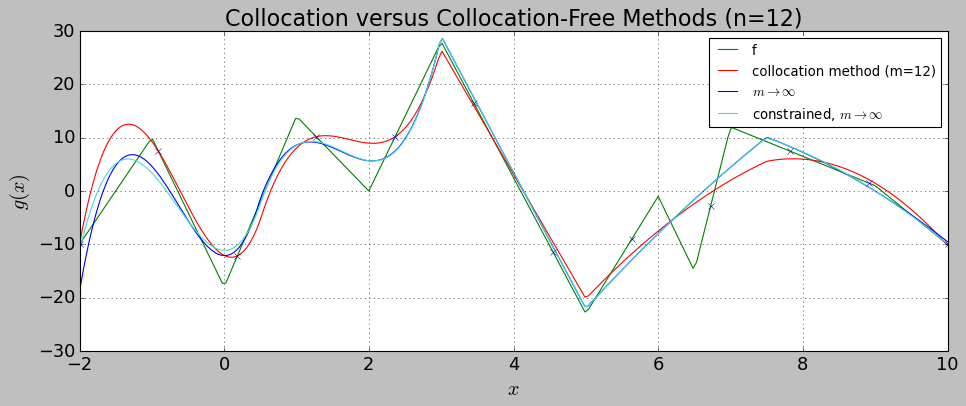

In [27]:
'''Code for comparison to collocation and unconstrainted methods'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation method (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_3))
plt.plot(x_pts, g_best_vec_3, '-', color='turquoise', label=r'constrained, $m\rightarrow \infty$')

#plt.plot([p[0] for p in shape_pts], [p[1] for p in shape_pts],'r*')
plt.plot(x_tilde_pts, f(x_tilde_pts), 'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** Constrained and unconstrained continuous least-squares give similar approximation in the interior of the domain. On the end points, the constrained method nearly matches the end values of the target function.

## [Experiment #1](#toc)<a id="ex1"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:(a,b)\in\Reals\rightarrow \Reals$.

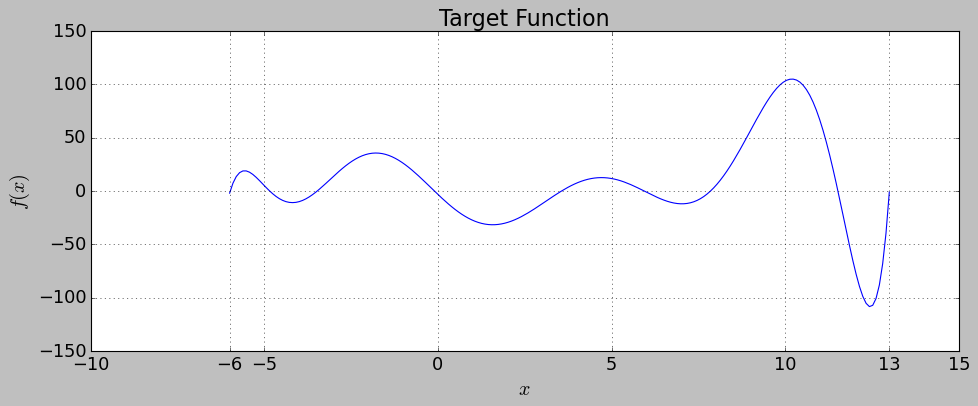

In [28]:
'''Consider another function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-6,-2), (-5,5), (-4,-10), (-3,14), (-1,26), (3,-12), (6, -1), (7, -12), (8,5), (13,-1)]
#print('# shape pts = ', len(shape_pts))
assert len(shape_pts) <= 10

f = TargetFunction(shape_pts, type='legendre')
f.plot(n_plot_pts=200, title='Target Function')

In [29]:
'''Degree of target function (Legendre polynomial)'''

print('degree = ',f.degree)

degree =  9


### [Collocation Approximation](#toc)<a id="ex1_coll"></a>

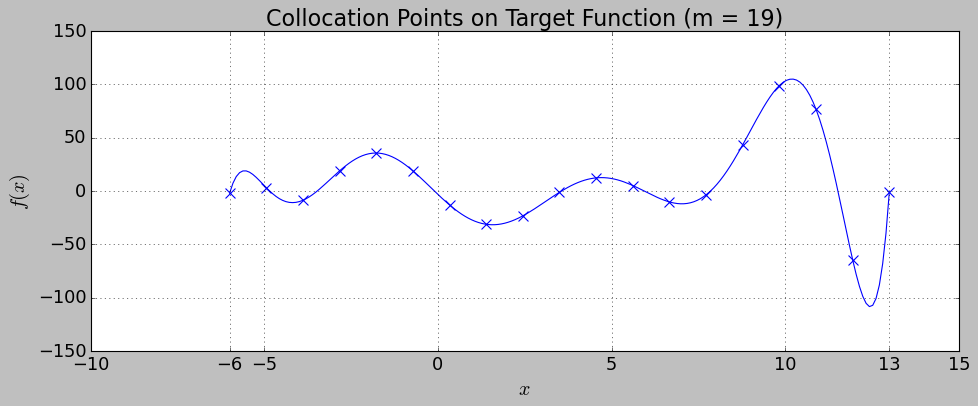

In [30]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 19

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, title='Collocation Points on Target Function (m = '+str(m)+')')

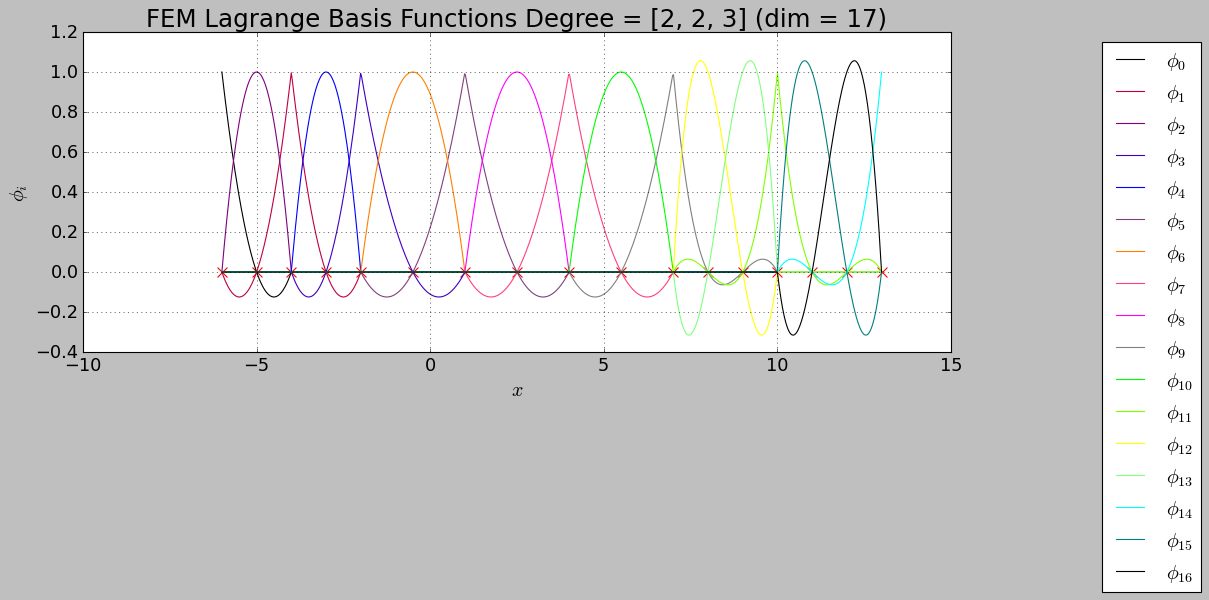

In [31]:
'''Build the basis functions'''

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

try:    
    from engy_5310.toolkit import LagrangeFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
femlb = LagrangeFEMBasis(degree=[2,2,3], n_elem=[2,3,2], x_partition=[x_min, -2, 7, x_max])
femlb.plot(n_plot_pts=800)

In [32]:
'''Build the basis function collocation matrix and target function vector at the collocation points'''

a_tilde_mtrx = femlb.evaluation_matrix(x_tilde_pts)
f_tilde_vec = f(x_tilde_pts)

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')
    
try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is overdetermined.
A is full rank.


In [33]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank; solve for least squares.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient; solve for shortest least squares')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-7)

print('')
print('c_tilde_star_vec:\n',c_tilde_star_vec)

        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank; solve for least squares.

c_tilde_star_vec:
 [ -2.  -11.8   3.4  38.9  14.7 -33.8  12.1  12.5 -21.7 -16.9   6.4 106.7   6.4  55.2  -1.   62.2
 -69.2]

||r^*||_2 =  3.182e+00


In [34]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = femlb.evaluation_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

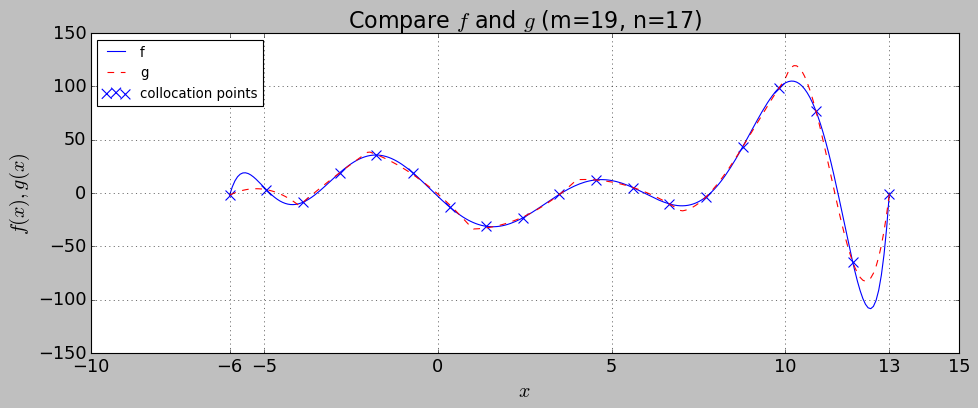

In [35]:
'''Plot comparison of f and g_vec'''

n_pts = max(2*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_1 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_1), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ (m='+str(m)+', n='+str(len(femlb.basis_func_list))+')')

In [36]:
'''Relative L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 = %5.2e %5.2e'%f.l2_norm)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)
print('||g||_L2 = %5.2e'%(math.sqrt(g2_integral)))
print('quadrature error = %5.2e'%error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 1.77e+02 3.48e-10

||g||_L2 = 1.72e+02
quadrature error = 3.63e-04

||f-g||_L2 = 30.73786366410476
quadrature error = 6.1125996353439405e-06

Relative error [%] = 17.367690629919146


Positives at collocation pts =  9
Negatives at collocation pts =  6
Positives =  141
Negatives =  158


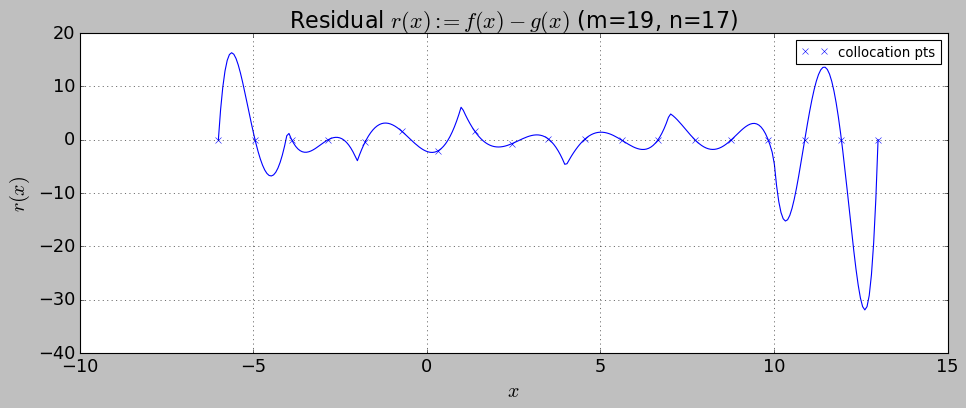

In [37]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(4 * m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)

print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f(x_tilde_pts)-g_best_vec_func(x_tilde_pts), 'bx', label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (m='+str(m)+', n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ex1_cont"></a>

In [38]:
'''Build the Gram matrix'''

gram_mtrx = femlb.gram_matrix()

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [39]:
'''Build load vector'''

b_vec = np.zeros(len(femlb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(femlb.basis_func_list):
    (b_vec[i], _) = femlb.inner_product(f, phi_i)  

In [40]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

In [41]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    a_mtrx = femlb.evaluation_matrix(x_pts)
    return a_mtrx@c_star_vec

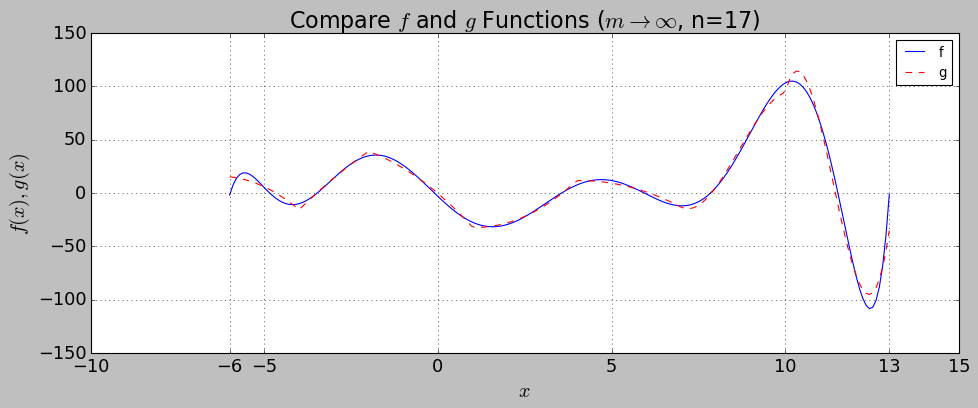

In [42]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')')

In [43]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 176.9830216295594

||g||_L2 = 175.88289082158127

||f-g||_L2 = 19.70275725311596

Relative error [%] = 11.132569142341527


Positives =  125
Negatives =  125


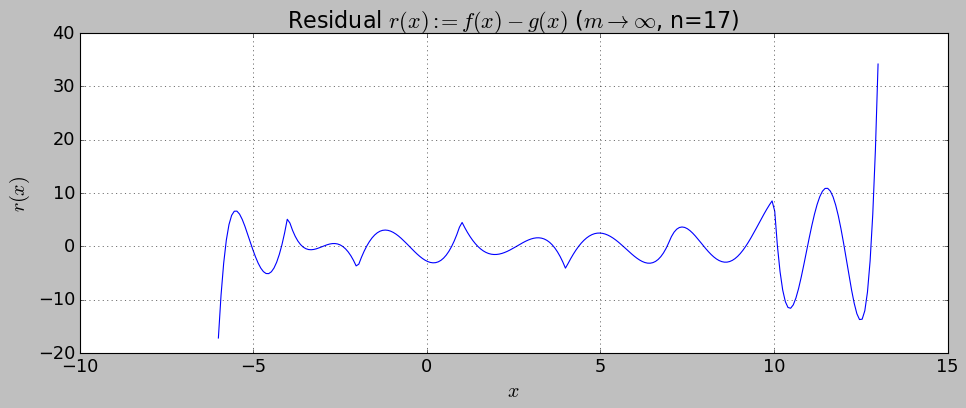

In [44]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ ($m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

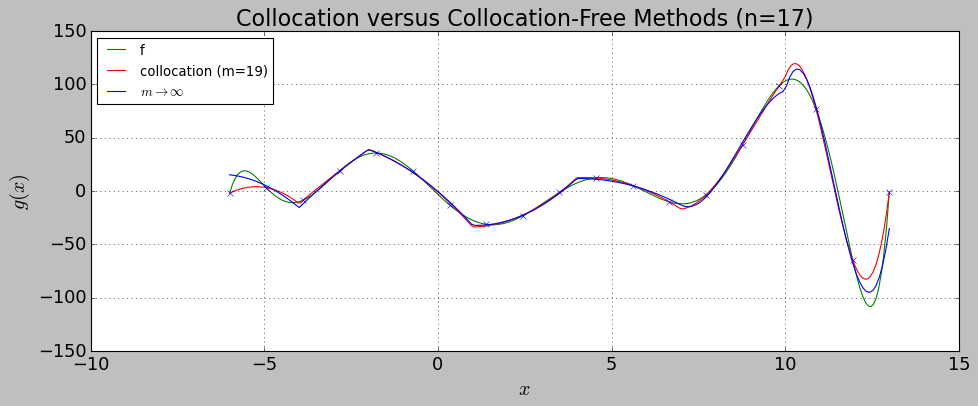

In [45]:
'''Code for comparison to collocation method'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')

plt.plot(x_tilde_pts, f(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** The end points of the approximation in the continuous case ($m\rightarrow \infty$) are not as well approximated compared to the collocation method. This is because the continuous case leaves the end points unconstrained. In this case, this effect is very pronounced.

### [Contrained Continuous Approximation ($m\rightarrow\infty$)](#toc)<a id="ex1_ctr_cont"></a>

In [46]:
'''Build the Gram matrix'''

gram_mtrx = femlb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [47]:
'''Build load vector'''

b_vec = np.zeros(len(femlb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(femlb.basis_func_list):
    (b_vec[i], _) = femlb.inner_product(f, phi_i) \
                  + f(x_min)*phi_i(x_min) + f(x_max)*phi_i(x_max)      

In [48]:
'''Compute optimal coefficient vector'''

c_star_vec = solve(gram_mtrx, b_vec)

In [49]:
'''Build the best approximant function'''

def g_best_vec_func(x):
    a_mtrx = femlb.evaluation_matrix(x)
    return a_mtrx@c_star_vec

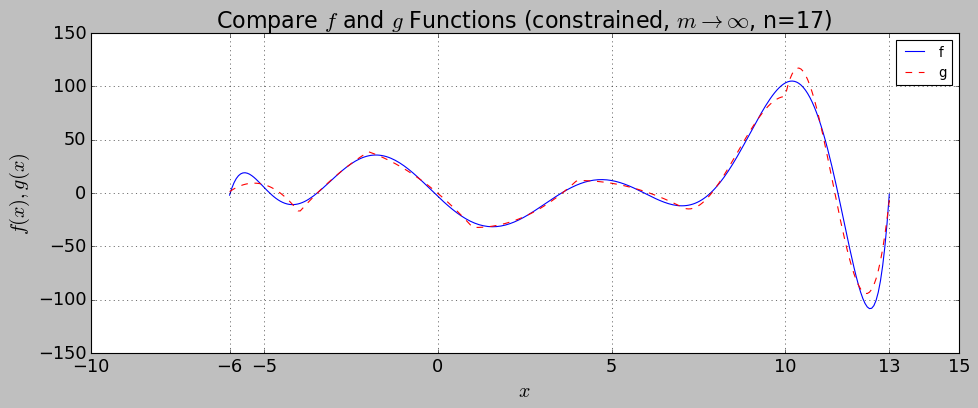

In [50]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2*m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

g_best_vec_3 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_3), n_plot_pts=n_pts, title=r'Compare $f$ and $g$ Functions (constrained, $m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')')

In [51]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(x)
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=500)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f(x)
    g_vec = g_best_vec_func(x)
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=500)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 176.9830216295594

||g||_L2 = 175.06967933568012

||f-g||_L2 = 24.343465384035042

Relative error [%] = 13.754689664519343


Positives =  121
Negatives =  129


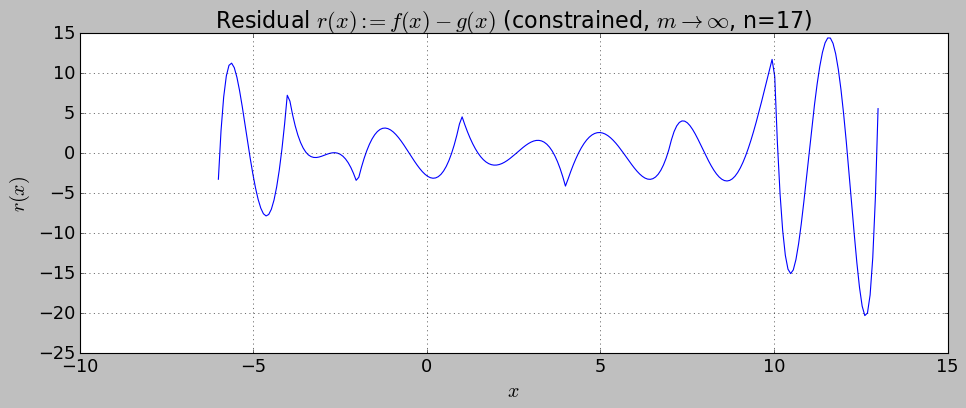

In [52]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')

n_pts = max(3*m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$ (constrained, $m\rightarrow\infty$, n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.show()

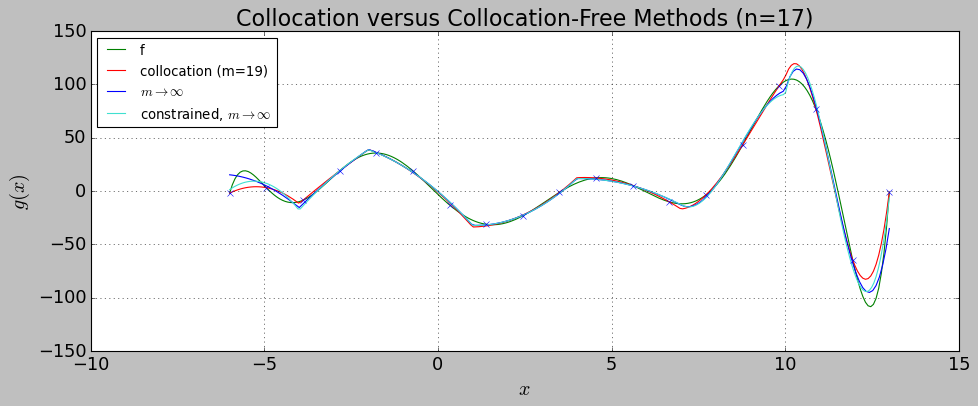

In [53]:
'''Code for comparison to unconstrained and collocation methods'''

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

x_pts = np.linspace(x_min, x_max, len(g_best_vec_1))
plt.plot(x_pts, f(x_pts),'g-',label='f')
plt.plot(x_pts, g_best_vec_1, 'r-', label='collocation (m='+str(m)+')')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_2))
plt.plot(x_pts, g_best_vec_2, 'b-', label=r'$m\rightarrow \infty$')
x_pts = np.linspace(x_min, x_max, len(g_best_vec_3))
plt.plot(x_pts, g_best_vec_3, '-', color='turquoise', label=r'constrained, $m\rightarrow \infty$')

plt.plot(x_tilde_pts, f(x_tilde_pts),'bx')

plt.title(r'Collocation versus Collocation-Free Methods (n='+str(len(femlb.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$g(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

**NB:** Here the end points are better approximated by the constrained method but the overall approximation has higher error because the interior approximation is adversely affected.